In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220727_VARprocess_EC_allsubjects_180.0s_segment_3600.0s_VARlength"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010069_EC    10
sub-010071_EC    10
sub-010072_EC    10
sub-010068_EC    10
sub-010065_EC    10
                 ..
sub-010060_EC    10
sub-010061_EC    10
sub-010062_EC    10
sub-010063_EC    10
sub-010064_EC    10
Length: 203, dtype: int64

10.0

9.89655172413793

<AxesSubplot:xlabel='order', ylabel='AIC'>

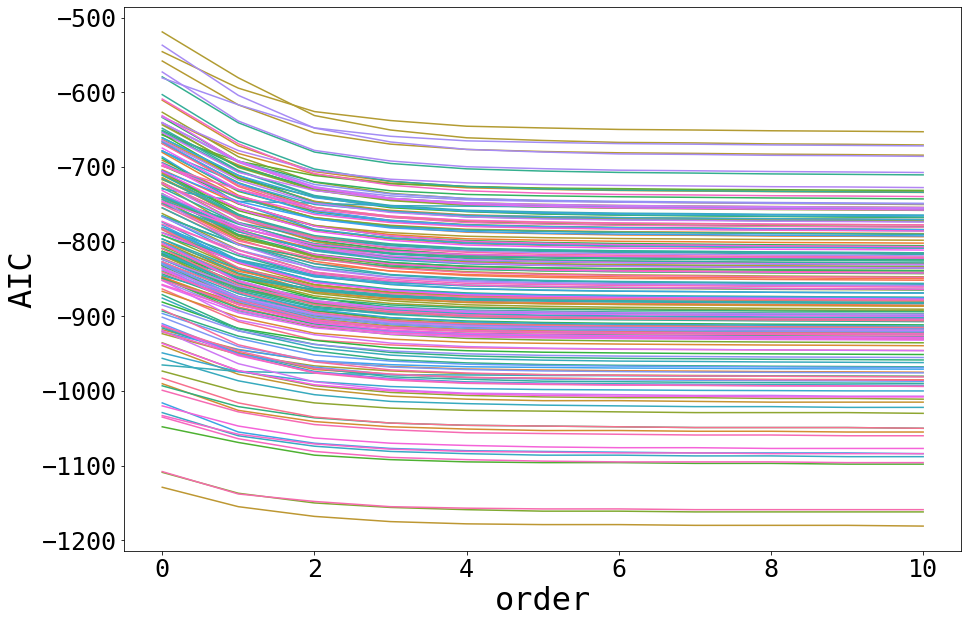

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_94153/2980343528.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_94153/2980343528.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


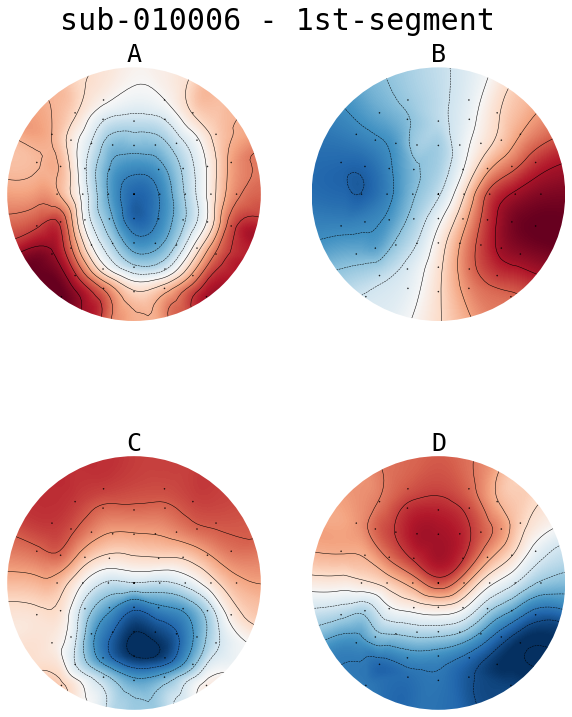

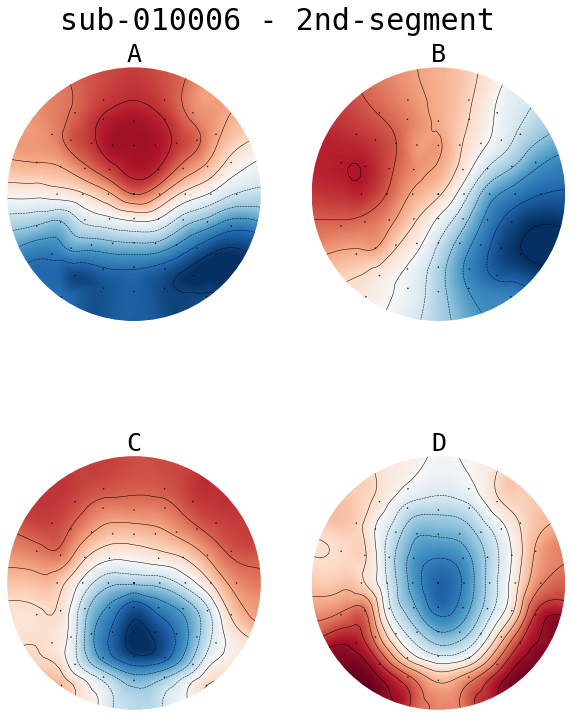

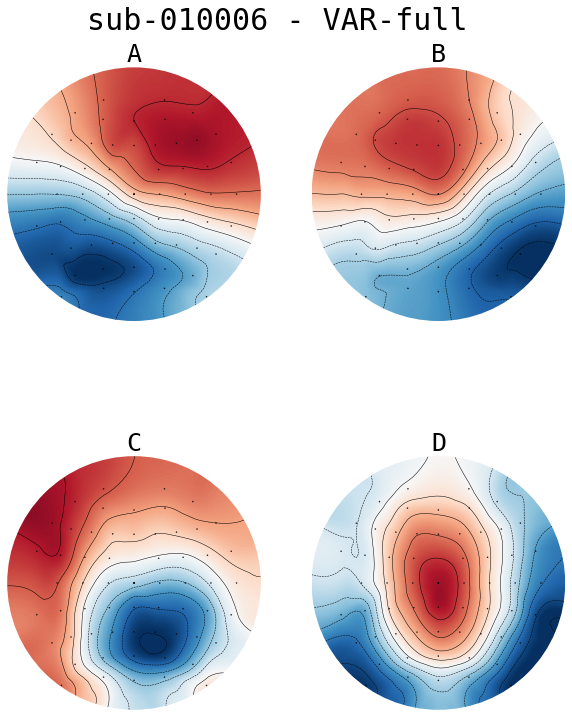

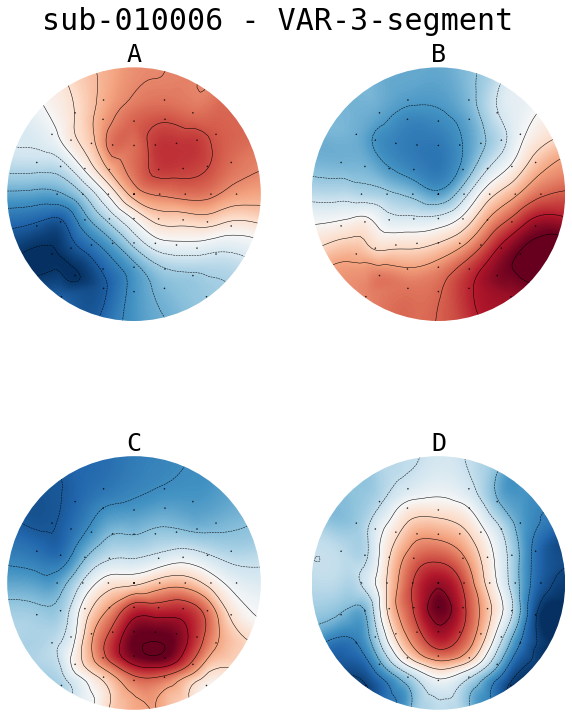

In [5]:
subj_id = "sub-010006"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-3-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
combined = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps_corrs.nc"))
SUBJECTS = list(combined["subj1"].values)

In [7]:
# reflect those matrices
stack_coords = ["latent map", "type1", "type2"]
reflected = []
for coords, dtarray in tqdm(combined.stack(all=stack_coords).groupby("all")):
    refl = np.triu(dtarray, k=1).T + np.nan_to_num(dtarray)
    refl = xr.DataArray(refl, dims=dtarray.dims, coords=dtarray.coords)
    refl = refl.assign_coords({k: v for k, v in zip(stack_coords, coords)}).expand_dims(
        stack_coords
    )
    reflected.append(refl)
reflected = xr.combine_by_coords(reflected).drop_vars("all")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2116/2116 [00:05<00:00, 375.42it/s]


In [8]:
var_mean = (
    reflected.isel({"type1": reflected["type1"].str.match("VAR-.*-segment")})
    .sel({"type2": "2nd-segment"})
    .mean("type1")
    .assign_coords({"type1": "VAR-segment-mean"})
    .expand_dims(["type1", "type2"])
)
combined = xr.concat([reflected, var_mean], dim="type1")

In [9]:
combined

<xarray.DataArray (latent map: 4, type1: 24, type2: 23, subj1: 203, subj2: 203)>
array([[[[[1.00000000e+00, 7.76852966e-01, 1.20425394e-01, ...,
           5.17108477e-01, 6.83319433e-01, 8.33707427e-02],
          [7.76852966e-01, 1.00000000e+00, 3.62112435e-01, ...,
           7.12584268e-01, 6.33216018e-01, 3.91105204e-01],
          [1.20425394e-01, 3.62112435e-01, 1.00000000e+00, ...,
           5.09993579e-01, 2.33884904e-01, 8.34721801e-01],
          ...,
          [5.17108477e-01, 7.12584268e-01, 5.09993579e-01, ...,
           1.00000000e+00, 5.03093886e-01, 4.77377350e-01],
          [6.83319433e-01, 6.33216018e-01, 2.33884904e-01, ...,
           5.03093886e-01, 1.00000000e+00, 2.36540250e-01],
          [8.33707427e-02, 3.91105204e-01, 8.34721801e-01, ...,
           4.77377350e-01, 2.36540250e-01, 1.00000000e+00]],

         [[8.40475362e-01, 6.84599414e-01, 1.91522519e-01, ...,
           5.26307383e-01, 6.67013947e-01, 5.41307134e-01],
          [6.84599414e-01, 9.62155597e-01, 4.07897601e-01, ...,
           7.31783777e-01, 6.58819052e-01, 6.47771505e-01],
          [1.91522519e-01, 4.07897601e-01, 9.88138110e-01, ...,
           5.88955057e-01, 2.99681507e-01, 4.49344413e-01],
...
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan]],

         [[           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          ...,
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan]]]]])
Coordinates:
  * type2       (type2) <U14 '1st-segment' '2nd-segment' ... 'VAR-full'
  * subj1       (subj1) object 'sub-010002' 'sub-010003' ... 'sub-010321'
  * subj2       (subj2) object 'sub-010002' 'sub-010003' ... 'sub-010321'
  * latent map  (latent map) <U1 'A' 'B' 'C' 'D'
  * type1       (type1) <U16 '1st-segment' '2nd-segment' ... 'VAR-segment-mean'

Text(232.07710997442462, 0.5, 'seg. VAR $\\to$ 2nd seg.')

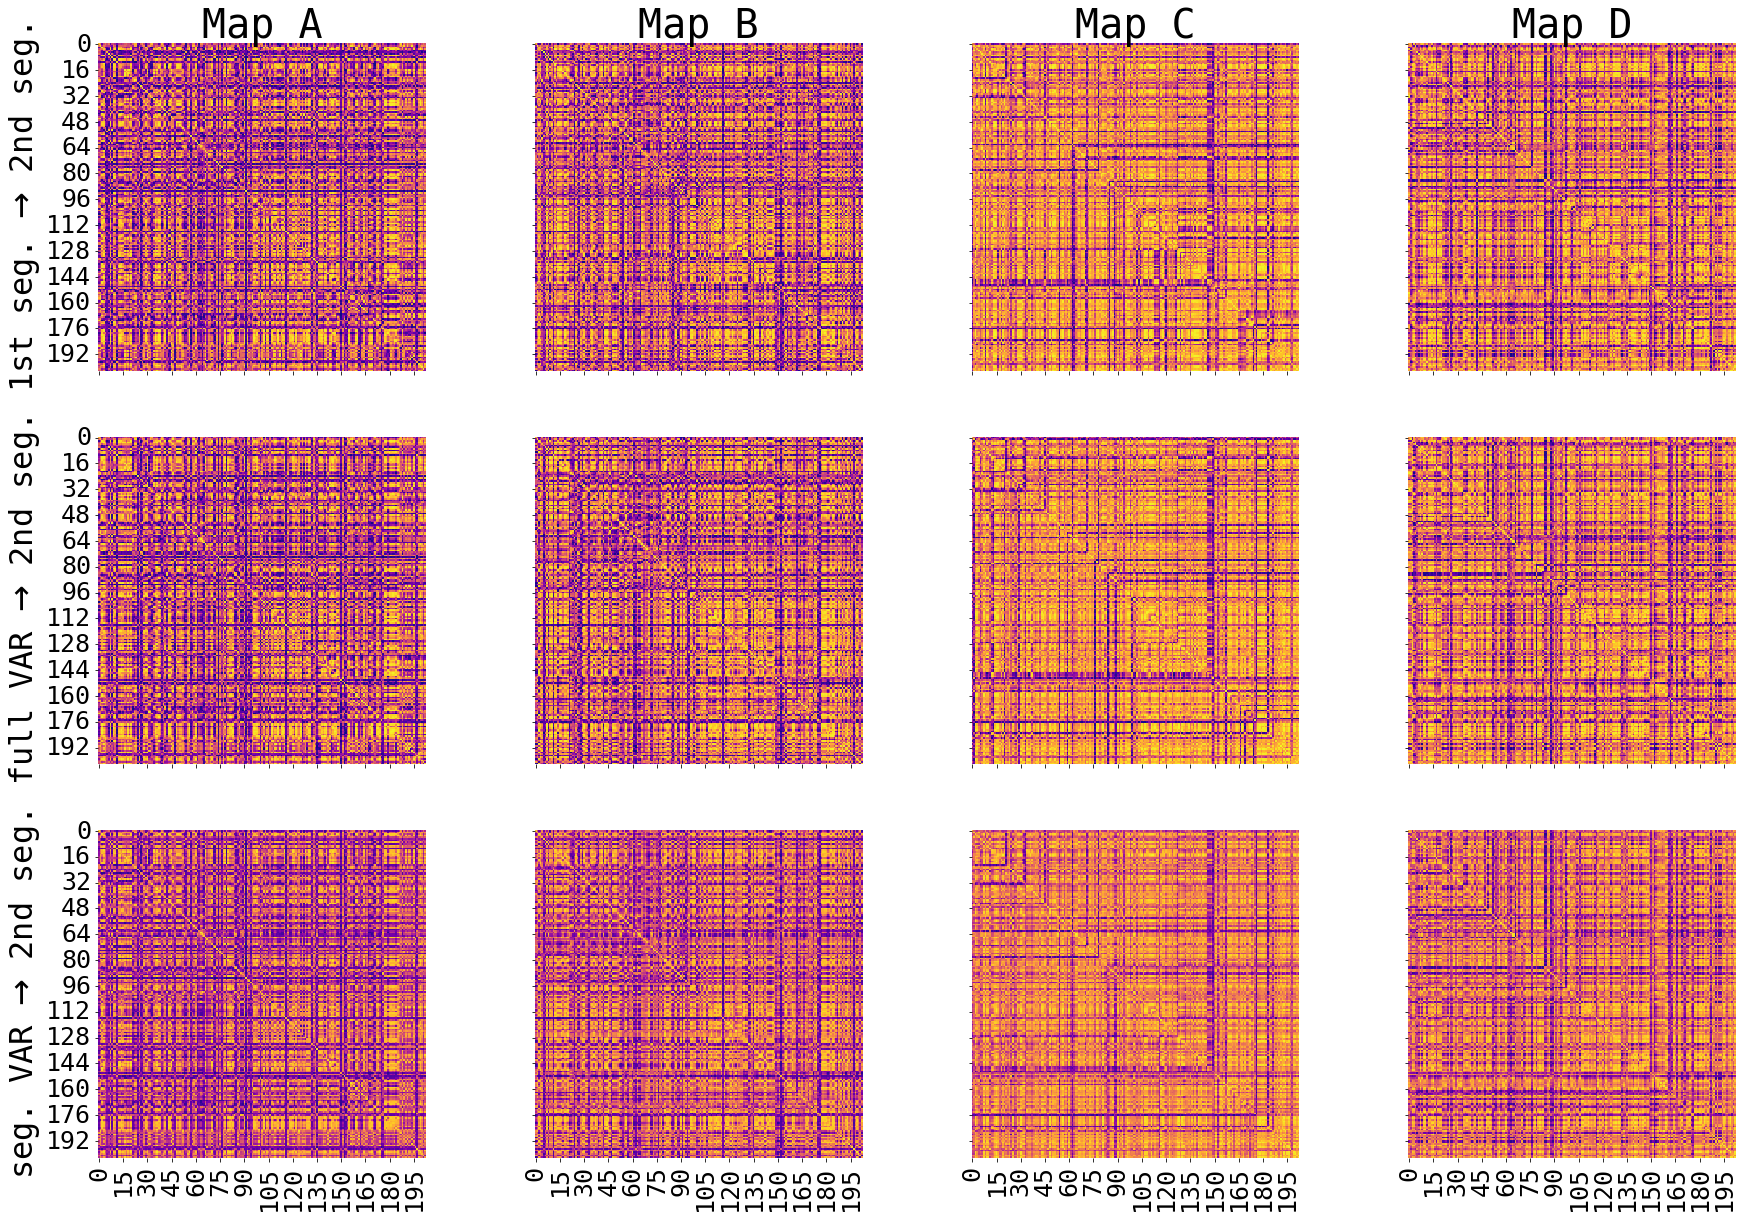

In [10]:
fig, axs = plt.subplots(
    nrows=3, ncols=4, squeeze=True, figsize=(30, 20.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full", "VAR-segment-mean"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")
axs[2, 0].set_ylabel(r"seg. VAR $\to$ 2nd seg.")

Text(232.07710997442462, 0.5, 'seg. VAR $\\to$ 2nd seg.')

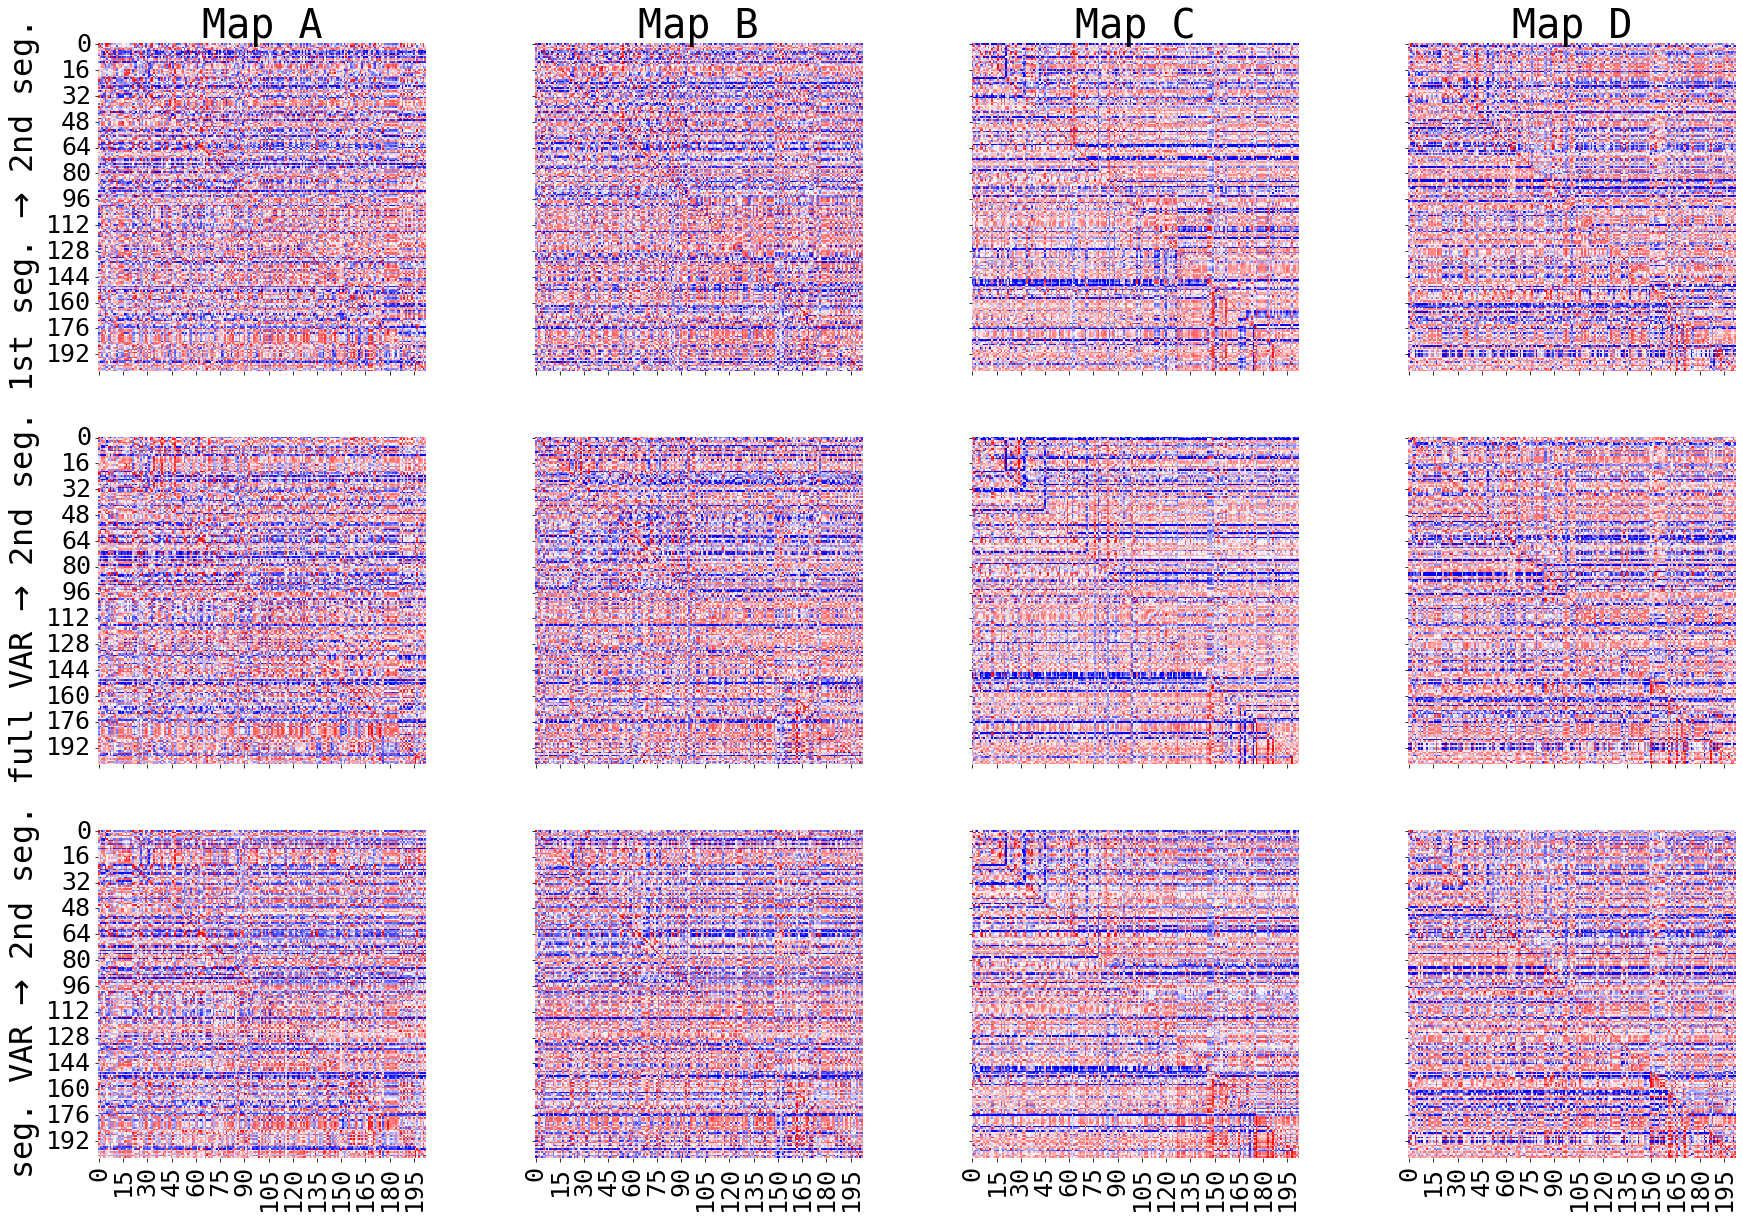

In [11]:
fig, axs = plt.subplots(
    nrows=3, ncols=4, squeeze=True, figsize=(30, 20.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full", "VAR-segment-mean"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")
axs[2, 0].set_ylabel(r"seg. VAR $\to$ 2nd seg.")

In [12]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values),
    index=["1st-segment", "VAR-full", "VAR-segment-mean"],
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full", "VAR-segment-mean"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values),
    index=["1st-segment", "VAR-full", "VAR-segment-mean"],
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full", "VAR-segment-mean"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

A   B   C   D
1st-segment       71  77  72  66
VAR-full          84  75  61  62
VAR-segment-mean  61  62  50  59

A   B   C   D
1st-segment       71  77  72  66
VAR-full          84  75  61  62
VAR-segment-mean  61  62  50  59

# Static and dynamic stats

In [13]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010002 1st-segment       A           0.674958   0.613279       0.959864   
                             B           0.674958   0.613279       0.779944   
                             C           0.674958   0.613279       0.802338   
                             D           0.674958   0.613279       0.821960   
           2nd-segment       A           0.679227   0.622642       0.687230   
...                                           ...        ...            ...   
sub-010319 VAR-segments-mean D           0.755729   0.700874       0.885187   
sub-010321 VAR-segments-mean A           0.852926   0.792523       0.821974   
                             B           0.852926   0.792523       0.884828   
                             C           0.852926   0.792523       0.914823   
                             D           0.852926   0.792523       0.943561   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010002 1st-segment       A           0.245817   17.299616  14.209377   
                             B           0.256372   18.621808  13.767303   
                             C           0.217728   15.510766  14.035817   
                             D           0.280083   19.571787  14.313458   
           2nd-segment       A           0.264594   18.888469  14.008235   
...                                           ...         ...        ...   
sub-010319 VAR-segments-mean D           0.247403   13.046947  18.936772   
sub-010321 VAR-segments-mean A           0.228382   14.636635  15.590652   
                             B           0.243484   14.903574  16.321716   
                             C           0.264391   13.936928  18.975619   
                             D           0.263743   13.953595  18.898223   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010002 1st-segment       A                0.718496       0.087688   
                             B                0.090751       0.709457   
                             C                0.098500       0.084618   
                             D                0.087433       0.123215   
           2nd-segment       A                0.714454       0.103804   
...                                                ...            ...   
sub-010319 VAR-segments-mean D                0.069564       0.069241   
sub-010321 VAR-segments-mean A                0.737548       0.104956   
                             B                0.084530       0.749358   
                             C                0.067243       0.073559   
                             D                0.079213       0.064027   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010002 1st-segment       A                0.084343       0.109474  
                             B                0.085984       0.113808  
                             C                0.715015       0.101868  
                             D                0.068867       0.720486  
           2nd-segment       A                0.096498       0.085244  
...                                                ...            ...  
sub-010319 VAR-segments-mean D                0.072748       0.788447  
sub-010321 VAR-segments-mean A                0.087011       0.070485  
                             B                0.076975       0.089137  
                             C                0.788450       0.070748  
                             D                0.068914       0.787846  

[3248 rows x 10 columns]

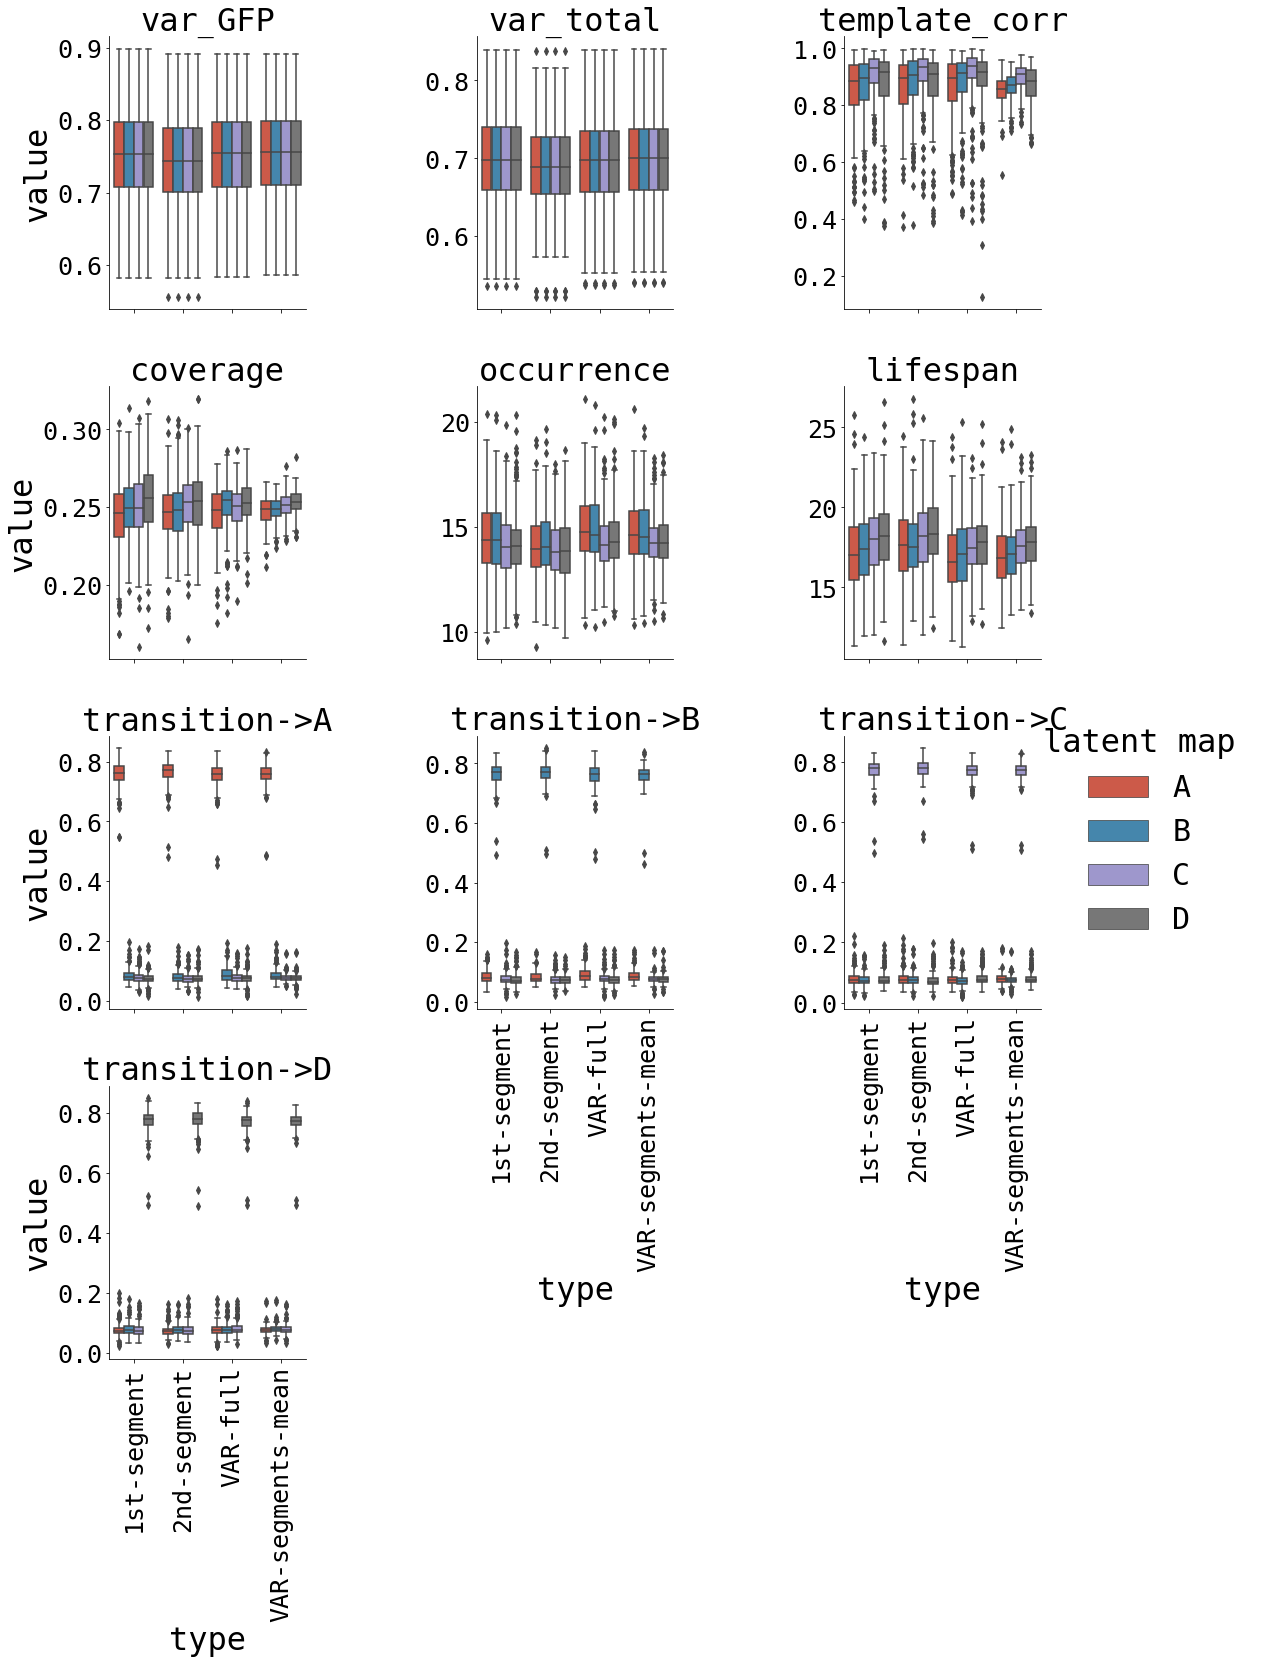

In [14]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
        "transition->A",
        "transition->B",
        "transition->C",
        "transition->D",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [15]:
static_stats_final["template_corr"].groupby(["type", "latent map"]).agg(
    ["mean", "median"]
)

mean    median
type              latent map                    
1st-segment       A           0.852438  0.885913
                  B           0.860365  0.896134
                  C           0.901301  0.929060
                  D           0.873572  0.917036
2nd-segment       A           0.860275  0.895431
                  B           0.874346  0.905418
                  C           0.905288  0.933903
                  D           0.864921  0.907976
VAR-full          A           0.858523  0.896489
                  B           0.875666  0.914755
                  C           0.906449  0.936684
                  D           0.877311  0.915506
VAR-segments-mean A           0.854157  0.858151
                  B           0.866106  0.871337
                  C           0.900122  0.908979
                  D           0.872426  0.885187

In [16]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    ) ** 2
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

df1 = static_stats_final.reset_index()
var_mean_segments = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - df1[df1["type"] == "VAR-segments-mean"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_mean_segments["diffs"] = "VAR-segments-mean"
static_diffs = pd.concat(
    [real_data_diff, var_full_diff, var_mean_segments]
).reset_index()

In [17]:
SIMPLE_MEAN = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
]

TRANS = ["transition->A", "transition->B", "transition->C", "transition->D"]

simple_means = static_diffs.groupby(["subject_id", "diffs"])[SIMPLE_MEAN].mean()
trans_means = (
    static_diffs.groupby(["subject_id", "diffs"])[TRANS]
    .mean()
    .reset_index()
    .melt(id_vars=["subject_id", "diffs"])
    .groupby(["subject_id", "diffs"])["value"]
    .mean()
)
trans_means.name = "transition_matrix"
static_diffs = pd.concat([simple_means, trans_means], axis=1).reset_index()

In [18]:
DVS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition_matrix",
]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(
        pg.pairwise_ttests(
            data=static_diffs,
            dv=dv,
            within="diffs",
            subject="subject_id",
            padjust="fdr_by",
        )
    )

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  7.202072  0.000845  0.000119  0.620741

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0 -6.091167  202.0   two-sided  5.571031e-09  3.064067e-08   fdr_by   
1  0.300268  202.0   two-sided  7.642815e-01  1.000000e+00   fdr_by   
2  2.724089  202.0   two-sided  7.012962e-03  1.928565e-02   fdr_by   

        BF10    hedges  
0  1.572e+06 -0.021432  
1      0.082  0.002280  
2      2.854  0.024165

== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  5.153734  0.006164  0.000047  0.764052

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust    BF10    hedges  
0 -3.929748  202.0   two-sided  0.000117  0.000642   fdr_by  120.96 -0.014116  
1  0.069812  202.0   two-sided  0.944412  1.000000   fdr_by   0.079  0.000380  
2  2.344728  202.0   two-sided  0.020012  0.055032   fdr_by   1.138  0.014718

== template_corr ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2    404  20.637361  2.925306e-09  0.037887  0.743772

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  6.597692  202.0   two-sided  3.589383e-10  9.870803e-10   fdr_by   
1  0.209208  202.0   two-sided  8.344971e-01  1.000000e+00   fdr_by   
2 -6.627703  202.0   two-sided  3.038290e-10  9.870803e-10   fdr_by   

        BF10    hedges  
0   2.22e+07  0.446678  
1       0.08  0.017286  
2  2.609e+07 -0.468703

== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2    404  25.621441  3.341309e-11  0.050183  0.619259

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  4.452378  202.0   two-sided  1.403873e-05  3.860652e-05   fdr_by   
1 -3.717749  202.0   two-sided  2.602978e-04  4.772125e-04   fdr_by   
2 -6.627679  202.0   two-sided  3.038694e-10  1.671282e-09   fdr_by   

        BF10    hedges  
0    883.866  0.258772  
1     57.361 -0.318789  
2  2.608e+07 -0.508203

== occurrence ==


Source  ddof1  ddof2          F     p-unc  p-GG-corr       ng2       eps  \
0  diffs      2    404  12.895276  0.000004   0.000013  0.009511  0.868002   

   sphericity  W-spher       p-spher  
0       False  0.84793  6.311846e-08

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  5.610711  202.0   two-sided  6.581987e-08  3.620093e-07   fdr_by   
1  3.286471  202.0   two-sided  1.196248e-03  3.289682e-03   fdr_by   
2 -0.984778  202.0   two-sided  3.259113e-01  5.975041e-01   fdr_by   

        BF10    hedges  
0  1.463e+05  0.217996  
1     14.075  0.172882  
2      0.126 -0.048131

== lifespan ==


Source  ddof1  ddof2         F    p-unc  p-GG-corr       ng2       eps  \
0  diffs      2    404  8.002837  0.00039   0.002281  0.010966  0.656884   

   sphericity   W-spher       p-spher  
0       False  0.477662  5.644827e-33

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  5.815527  202.0   two-sided  2.335079e-08  1.284294e-07   fdr_by   
1 -0.155489  202.0   two-sided  8.765914e-01  1.000000e+00   fdr_by   
2 -3.409864  202.0   two-sided  7.847182e-04  2.157975e-03   fdr_by   

        BF10    hedges  
0  3.957e+05  0.250954  
1      0.079 -0.011431  
2      20.71 -0.222050

== transition_matrix ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F     p-unc       ng2       eps
0  diffs      2    404  14.144659  0.000001  0.020589  0.790177

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  6.104731  202.0   two-sided  5.185930e-09  2.852262e-08   fdr_by   
1  0.182442  202.0   two-sided  8.554189e-01  1.000000e+00   fdr_by   
2 -4.670039  202.0   two-sided  5.486177e-06  1.508699e-05   fdr_by   

        BF10    hedges  
0  1.684e+06  0.351635  
1       0.08  0.013090  
2   2149.572 -0.308667

In [19]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010002 1st-segment           2.752682  1.994177          2.0   
           2nd-segment           2.690565  1.995708          2.0   
           VAR-full              2.758094  1.995753          2.0   
sub-010003 1st-segment           4.027731  1.978721          2.0   
           2nd-segment           3.707810  1.986801          2.0   
...                                   ...       ...          ...   
sub-010316 VAR-segments-mean     3.762634  1.993536          2.0   
sub-010317 VAR-segments-mean     3.601694  1.995917          2.0   
sub-010318 VAR-segments-mean     3.000058  1.996255          2.0   
sub-010319 VAR-segments-mean     3.618150  1.995236          2.0   
sub-010321 VAR-segments-mean     3.575065  1.988076          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010002 1st-segment            1.261688         1.305920         100.0  
           2nd-segment            1.259163         1.304224          36.0  
           VAR-full               1.285182         1.328363          36.0  
sub-010003 1st-segment            1.000199         1.028645          52.0  
           2nd-segment            1.012374         1.041526          52.0  
...                                    ...              ...           ...  
sub-010316 VAR-segments-mean      1.046028         1.078941          52.0  
sub-010317 VAR-segments-mean      1.088193         1.130473          52.0  
sub-010318 VAR-segments-mean      1.193045         1.241364          44.0  
sub-010319 VAR-segments-mean      1.069078         1.103995          52.0  
sub-010321 VAR-segments-mean      1.097622         1.133991          52.0  

[812 rows x 6 columns]

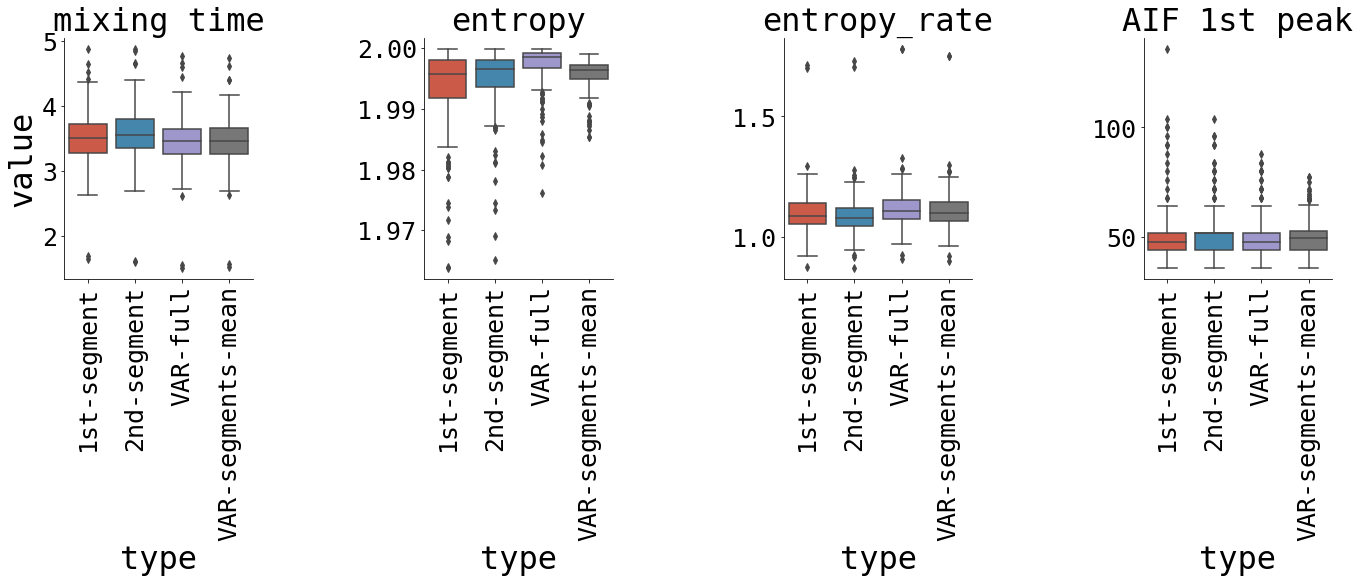

In [20]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [21]:
dynamic_stats

subject_id  mixing time   entropy  max entropy  entropy_rate  \
0   sub-010002     2.752682  1.994177          2.0      1.261688   
0   sub-010002     2.690565  1.995708          2.0      1.259163   
0   sub-010002     2.676522  1.997087          2.0      1.287428   
0   sub-010002     2.617044  1.991095          2.0      1.268671   
0   sub-010002     2.680674  1.996436          2.0      1.284218   
..         ...          ...       ...          ...           ...   
0   sub-010321     3.497763  1.998673          2.0      1.097130   
0   sub-010321     3.498247  1.996749          2.0      1.100755   
0   sub-010321     3.520647  1.979590          2.0      1.100626   
0   sub-010321     3.587774  1.977010          2.0      1.097433   
0   sub-010321     3.497147  1.993770          2.0      1.103359   

    MC entropy rate  AIF 1st peak            type  
0          1.305920         100.0     1st-segment  
0          1.304224          36.0     2nd-segment  
0          1.339164          36.0   VAR-1-segment  
0          1.320376          36.0  VAR-10-segment  
0          1.336350          76.0  VAR-11-segment  
..              ...           ...             ...  
0          1.130900          52.0   VAR-6-segment  
0          1.135672          52.0   VAR-7-segment  
0          1.138115          52.0   VAR-8-segment  
0          1.134332          52.0   VAR-9-segment  
0          1.133460          52.0        VAR-full  

[4669 rows x 8 columns]

In [22]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    ) ** 2
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = all_segments_diffs.reset_index().groupby(["subject_id"]).mean()

df1 = dynamic_stats_final.reset_index()
var_mean_segments = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - df1[df1["type"] == "VAR-segments-mean"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_mean_segments["diffs"] = "VAR-segments-mean"
dynamic_diffs = pd.concat(
    [real_data_diff, var_full_diff, var_mean_segments]
).reset_index()

In [23]:
dynamic_diffs

subject_id  mixing time       entropy  entropy_rate  AIF 1st peak  \
0    sub-010002     0.003859  2.344016e-06      0.000006        4096.0   
1    sub-010003     0.102350  6.527834e-05      0.000148           0.0   
2    sub-010004     0.093707  6.849267e-06      0.001661          16.0   
3    sub-010005     0.006544  1.130982e-06      0.000024          16.0   
4    sub-010006     0.000129  1.896077e-08      0.000041          64.0   
..          ...          ...           ...           ...           ...   
604  sub-010316     0.001332  1.737938e-05      0.000510           0.0   
605  sub-010317     0.003018  1.281301e-06      0.000213           0.0   
606  sub-010318     1.575145  6.651290e-06      0.030758        2304.0   
607  sub-010319     0.002961  1.779175e-05      0.000140          16.0   
608  sub-010321     0.000329  8.779205e-08      0.000006           0.0   

                 diffs  
0            real_data  
1            real_data  
2            real_data  
3            real_data  
4            real_data  
..                 ...  
604  VAR-segments-mean  
605  VAR-segments-mean  
606  VAR-segments-mean  
607  VAR-segments-mean  
608  VAR-segments-mean  

[609 rows x 6 columns]

In [24]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(
        pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id")
    )
    display(
        pg.pairwise_ttests(
            data=dynamic_diffs,
            dv=dv,
            within="diffs",
            subject="subject_id",
            padjust="fdr_by",
        )
    )

== mixing time ==


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  7.131236  0.000904  0.002675  0.553708

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust    BF10    hedges  
0  3.804511  202.0   two-sided  0.000188  0.001035   fdr_by  77.507  0.038773  
1  2.987266  202.0   two-sided  0.003163  0.008699   fdr_by    5.82  0.128122  
2  2.115171  202.0   two-sided  0.035641  0.065342   fdr_by   0.695  0.087478

== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  3.556142  0.029446  0.006912  0.624218

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust     BF10    hedges  
0  3.899990  202.0   two-sided  0.000131  0.000720   fdr_by  108.698  0.166373  
1 -0.264916  202.0   two-sided  0.791345  1.000000   fdr_by    0.081 -0.023420  
2 -2.378722  202.0   two-sided  0.018305  0.050338   fdr_by     1.23 -0.205258

== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2    404  54.055184  1.576140e-21  0.018743  0.548861

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

           T    dof alternative         p-unc        p-corr p-adjust  \
0  10.171354  202.0   two-sided  6.924224e-20  3.808323e-19   fdr_by   
1   7.834560  202.0   two-sided  2.629235e-13  7.230396e-13   fdr_by   
2   5.818655  202.0   two-sided  2.297978e-08  4.212959e-08   fdr_by   

        BF10    hedges  
0  6.681e+16  0.129024  
1  2.457e+10  0.339529  
2  4.018e+05  0.212653

== AIF 1st peak ==


Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  diffs      2    404  1.333862  0.264615    0.25209  0.002097  0.537202   

   sphericity   W-spher       p-spher  
0       False  0.138504  5.212144e-87

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust   BF10    hedges  
0  2.568229  202.0   two-sided  0.010944  0.060192   fdr_by  1.926  0.062213  
1 -0.783092  202.0   two-sided  0.434490  0.796566   fdr_by  0.106 -0.057171  
2 -1.321706  202.0   two-sided  0.187761  0.516342   fdr_by  0.185 -0.102949